In [1]:
# RUN: 'pip install jsonlines' on: ModuleNotFoundError: No module named 'jsonlines'
import json
import jsonlines
from tqdm import tqdm
import pandas as pd
import pickle

# RUN: 'pip install whoosh' on: ModuleNotFoundError: No module named 'whoosh'
import os, os.path

#from whoosh import index
import whoosh
from whoosh.index import create_in
from whoosh.fields import *
from whoosh.writing import AsyncWriter

from datetime import datetime
from pytz import timezone

from IPython.display import clear_output

######################################

class Indexer:
    '''This class is used to create index of the WP database'''
    
    index_created = False
    index_directory = ""
    data_path = ""
    # [id, article_url, title, author, publised_date, contents, type, source]
    # Define fields using whoosh's 'Schema' | https://whoosh.readthedocs.io/en/latest/schema.html#
    # Can add field boost here
    schema = Schema(doc_id = whoosh.fields.ID(unique=True, stored=True),\
                       article_url = whoosh.fields.STORED,\
                       title = whoosh.fields.TEXT(stored=True),\
                       author = whoosh.fields.ID,\
                       published_date = whoosh.fields.DATETIME,\
                       contents = whoosh.fields.TEXT)
    
    def __init__(self):
        print('Indexer has been initiated.')
        
    def indexCreated(self):
        return self.index_created
      
    ## Count documents
    def countDocuments(self):
        print("Counting documents, this might take a while...")
        counter = 0
        tenKCounter = 0

        with jsonlines.open(self.data_path) as reader:
            for obj in tqdm(reader.iter(type=dict, skip_invalid=True)):
                tenKCounter += 1
                counter += 1
            
                if tenKCounter >= 10000:
                    print("Current count is: " + str(counter))
                    tenKCounter = 0 
        print("Last count is: " + str(counter))
        print("Counting done.")
        
    def extractDocumentContents(self, contents):
        '''Extracts document contents from array of dicts to string'''
        build_string = ""
        json_array = json.dumps(str(contents))
        
        for item in json_array:
            try:
                print(str(item['type']))
                if str(item['type']) == "sanitized_html":
                    build_string = build_string + str(item['content'])
                    build_string = build_string + "\n"
            except:
                build_string = "Could not retreive content"
        
        print(build_string)
        return build_string
    
    def extractDocumentDate(self, epochTimestamp):
        '''Converst UNIX epoch timestamp to DATETIME'''
        if (epochTimestamp == ''):
            return datetime(1,1,1)
        try:
            # Test if source is within specified dates
            date_info = epochTimestamp
            removed_zeros = str(date_info)[0:10]
            timestamp = int(removed_zeros)
            return datetime.fromtimestamp(timestamp, timezone('EST'))
        except:
            print("ERROR: In extractDocumentDate()")
            print("ERROR: ", sys.exc_info()[0])
            #print("Caused by value: " + str(date_info))
            return datetime(1,1,1)
    
    def setIndexDirectory(self, directory):
        self.index_directory = directory
    
    def getIndexLocation(self):
        return self.index_directory
    
    def setDataPath(self, file_location):
        self.data_path = file_location
    
    def getDataPath(self):
        return self.data_path
    
    def setIndexCreatedTrue(self):
        self.index_created = True
    
    def getSchema(self):
        return self.schema
    
    def index(self):
        '''This method indexes the data'''
        # https://whoosh.readthedocs.io/en/latest/api/writing.html
        # https://appliedmachinelearning.blog/2018/07/31/developing-a-fast-indexing-and-full-text-search-engine-with-whoosh-a-pure-python-library/
        
        assert self.index_directory and self.data_path # Both variables have to be set
        
        schema = self.getSchema()
              
        # Creating a index writer to add document as per schema
        myindex = whoosh.index.create_in(self.index_directory, schema)
        writer = whoosh.writing.AsyncWriter(myindex)
        
        # Loop over data
        print("Looping over data. Indexing each article.")
        print("This might take a few minutes...")
        counter = 0
        checker = 10000
        fault_counter = 0
        with jsonlines.open(self.data_path) as reader:
            for obj in tqdm(reader.iter(type=dict, skip_invalid=True)):
                retreived_date = self.extractDocumentDate(obj['published_date'])
                if retreived_date != datetime(1,1,1):
                    counter = counter + 1
                    writer.add_document(doc_id=obj['id'],\
                                        article_url=obj['article_url'],\
                                        title=obj['title'],\
                                        author=obj['author'],\
                                        published_date=retreived_date,\
                                        contents = self.extractDocumentContents(obj['contents']))
                else:
                    fault_counter = fault_counter + 1
                    
                if counter > checker:
                    writer.commit()
                    writer = whoosh.writing.AsyncWriter(myindex)
                    checker = checker + 10000
                    clear_output(wait=True)
                    print("Looping over data. Indexing each article.")
                    print("This might take a few minutes...")
                    print("Indexed " + str(counter - 1) + " articles")
                    break
                    if fault_counter > 0:
                        print("Found " + str(fault_counter) + " wrongly formatted articles")
            
            print("Looping complete.")
        print("Index created!")
        self.setIndexCreatedTrue()
        

In [2]:
###############################################
from whoosh.qparser import QueryParser, MultifieldParser
from whoosh import scoring
from whoosh.index import open_dir

class Ranking:
    '''This class contains functions that are used to create a ranking based on different algorithms'''
    
    show_n_results = 3
    index_directory = ""
    
    def __init__(self):
        print("Ranking class has been initiated.")
    
    def indexCreated(self):
        return indexCreated
    
    def setIndexDirectory(self, directory):
        self.index_directory = directory
    
    def openIndex(self):
        assert self.index_directory
        return open_dir(self.index_directory)
    
   
    def resultsToList(self, results):
        results_list = []
        for result in results:
            result_dict = result.fields()
            result_dict['score'] = result.score
            results_list.append(result_dict)
        return results_list
            
    
    def searchWithSelectedAlgorithm(self, user_query, indexer, scoring_algorithm):
    #TODO check if index has been created
        index_dir = indexer.getIndexLocation()
        self.setIndexDirectory(index_dir)
        index = self.openIndex()
        results_list = []
        schema = indexer.getSchema()
        fields = schema.scorable_names()
        
        with index.searcher(weighting=scoring_algorithm) as searcher:
            #parsed_query = QueryParser("title", index.schema).parse(user_query)
            parsed_query = MultifieldParser(fields, schema).parse(user_query)
            results = searcher.search(parsed_query, limit=self.show_n_results)
            results_list = self.resultsToList(results)
        
        return results_list
    
    
    
    def searchTermFrequency(self, user_query, indexer):
        '''Returns results for a given query based on the TF-IDF search algorithm. Returned value is a list of dictionaries.'''
        scoring_algorithm = scoring.Frequency
        return self.searchWithSelectedAlgorithm(user_query, indexer, scoring_algorithm)
            
    
    def searchTF_IDF(self, user_query, indexer):
        '''Returns results for a given query based on the TF-IDF search algorithm. Returned value is a list of dictionaries.'''
        scoring_algorithm = scoring.TF_IDF
        return self.searchWithSelectedAlgorithm(user_query, indexer, scoring_algorithm)
    
    def searchBM25F(self, user_query, indexer):
        '''Returns results for a given query based on the BM25F search algorithm. Returned value is a list of dictionaries.'''
        scoring_algorithm = scoring.BM25F(B=0.75, content_B=1.0, K1=1.5)
        return self.searchWithSelectedAlgorithm(user_query, indexer, scoring_algorithm)
    
    
    
#     def searchTermFrequencyReturnResults(self, user_query):
#     #TODO check if index has been created
#         index = self.openIndex()

#         with index.searcher(weighting=scoring.Frequency) as searcher:
#             parsed_query = QueryParser("title", index.schema).parse(user_query)
#             results = searcher.search(parsed_query)            
#             return results

    
#     def searchBM25FReturnResults(self, user_query):
#         index = self.openIndex()
#         with index.searcher(weighting=scoring.BM25F(B=0.75, content_B=1.0, K1=1.5)) as searcher:
#             parsed_query = QueryParser("title", index.schema).parse(user_query)
#             results = searcher.search(parsed_query)            
#             return results  
        

In [11]:
################################################
import urllib
import matplotlib.pyplot as plt

class Evaluation:
    '''Used to evaluate the ranking results'''
    #should check if query used is in the 
    
    # TODO load evaluation document and queries
    # TODO pass queries on to ranking and obtain ranking results
    # TODO compare ranking results to TREC evaluation
    # TODO display results, how?
    # TODO test different algorithms
    
    queries = []
    ranking = Ranking()
    
    def load_queries(self):
        
        query_url = "https://trec.nist.gov/data/core/topics2018.txt"
        query_file = urllib.request.urlopen(query_url)
        titles, numbers = [], []
        title = False
        
        for line in query_file:
            decoded_line = line.decode("utf-8")
            
            if title and not "</title>" in decoded_line:
                titles.append(decoded_line.replace("\n", "").strip())

            if "<title>" in decoded_line:
                title = True
            
            if "</title>" in decoded_line:
                title = False
                
            if "<num>" in decoded_line:
                num = decoded_line.replace("<num>", "").replace("</num>", "").replace("\n", "").replace("Number: ", "").strip()
                numbers.append(num)
        
        queries = list(zip(titles, numbers))
        return queries 

        
    def addResults(self, results_formatted, results, query, number):
        count = 0
        
        for hit in results: 
            score = int(hit['score'])
                
            current_result = str(number) + " 0 "  + str(hit["doc_id"]) + " " + str(score)           
            results_formatted.append(current_result)
            
            count += 1
        print("for query {} there are {} hits".format(query, count))
        return results_formatted
        
        
    def writeResults(self, results):
        
        with open("results.txt", "w") as results_file:
            for result in results:
                results_file.write(result + "\n")
    
    def plotResults(self):
        
        all_scores = []
        
        with open("results.txt", "r") as results_file:
            for line in results_file:
                current_result = line.split(" ")
                current_result = [i.strip("\n") for i in current_result]                    
                all_scores.append(int(float(current_result[-1])))
                
        _ = plt.hist(all_scores, bins='auto')  
        plt.title("Histogram with 'auto' bins")
        
        plt.show()
        
        print("Max score ", max(all_scores))
        print("Min score ", min(all_scores))
    
    def compareResults(self):        
        # read in results.txt
        predictions = []
        with open("results.txt", "r") as results_file:
            for line in results_file:
                current_result = line.split(" ")
                current_result = [i.strip("\n") for i in current_result]
                
                predictions.append(current_result)
                
        # read in true scores file
        true_scores = []
        true_scores_url = "https://trec.nist.gov/data/core/qrels2018.txt"
        true_scores_file = urllib.request.urlopen(true_scores_url)

        for line in true_scores_file:
            decoded_line = line.decode("utf-8")
            decoded_line = decoded_line.split(" ")
            decoded_line = [i.strip("\n") for i in decoded_line]
            
            true_scores.append(decoded_line)
        
        
        # compare results.txt (preds) with true scores
        #correct_preds, incorrect_preds = 0, 0
        
        best_performance = 0
        
        
        for lower_bound in [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]:
            for upper_bound in [26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48]:
                
                correct_preds, incorrect_preds = 0, 0
                matches_found = 0
                for pred in predictions:
                    for true_score in true_scores:

                        if pred[0] == true_score[0] and pred[2] == true_score[2]:
                            matches_found += 1

                            pred_score = 0
                            current_score = int(float(pred[3]))

                            if lower_bound < int(float(pred[3])) < upper_bound:
                                pred_score = 1
                            if upper_bound < int(float(pred[3])):
                                pred_score = 2

                            if pred_score == int(true_score[3]):
                                correct_preds += 1
                            else:
                                incorrect_preds += 1

                            break

                if correct_preds == incorrect_preds == 0:
                    print("No matches found, because doc id's do not yet work")

                else:
                    performance = correct_preds/(correct_preds+incorrect_preds) * 100
                    if performance > best_performance:
                        
                        print("For boundaries: [{}, {}]".format(lower_bound, upper_bound))
                        print("Matches found {} of {} predictions ".format(matches_found, len(predictions)))

                        print("Performance: {:.2f}%".format(performance))
                        print("Correct predictions: ", correct_preds)
                        print("Incorrect predictions: ", incorrect_preds)

                        best_performance = performance

        


Ranking class has been initiated.


In [12]:
##################################################
class UserInterface:
    '''Class used to handle user interaction'''
          
    def __init__(self):
        '''This is the constructor method of the UI'''
        print("UserInterface has been initiated.")       
        
    def getUserQuery(self):
        ''''Retrieves the query from the user and returns it'''
        userInput = input("Please enter a query: ")
        return userInput
    
    def indexAlreadyCreated(self, directory_location):
        print("Index is set.")
        print("Index files are stored in directory:" + directory_location)
        return
    
    def shouldCreateIndex(self):
        print("Do you wish to create a new index?")
        userInput = input("Answer [y/n]: ")
        if userInput == ('y' or 'Y' or "yes"):
            return True
        return False
    
    def indexIsNotSet(self):
        print("Index has not been set.")
        return
    
    def getIndexDirectory(self, default_directory):
        userInput = input("Please enter a directory name for the index (default = /"+ default_directory + "): ")
        if userInput == "":
            return default_directory
        return userInput
    
    def getDataPath(self, default_data_path):
        print("Please enter the path to the TREC_Washington_Post_collection.v2.jl file.")
        print("The default location is: /"+ default_data_path + "): ")
        userInput = input()
        if userInput == "":
            return default_data_path
        return userInput
    
    def creatingIndex(self, index_directory, data_path):
        print("Creating Index.")
        print("Selected index directory:\t" + index_directory)
        print("Selected file to index:\t" + data_path)
        
    def openingIndex(self, index_directory):
        print("Opening Index.")
        print("Selected index directory to use:\t" + index_directory)
    
    def shouldAddExistingIndex(self):
        print("Do you wish to add an existing index?")
        userInput = input("Answer [y/n]: ")
        if userInput == ('y' or 'Y' or "yes"):
            return True
        return False
    
    def stopSearchEngine(self):
        print("Search Engine is stopped.")
        
    def shouldTerminateSearchEngine(self):
        print("Do you wish to stop the search engine?")
        userInput = input("Answer [y/n]: ")
        if userInput == ('y' or 'Y' or "yes"):
            return True
        return False
    
    def printResults(self, results):
        if len(results) > 0:
            print("\nPrinting results:")
            counter = 1
            for result in results:
                print("Result " + str(counter) + ":")
                print(result)
                print("")
                counter += 1
            return
        print("No results found")
        return
            
    

In [13]:
import time

class SearchEngine:
    '''This class embodies the search engine and acts a a controller class'''
    
    UI = None
    Indexer = None
    Ranking = None
    
    RUNNING = False
    STOPPED = False
    EVALUATION_MODE = True
    USER_MODE = False
    
    user_query = ""
    DEFAULT_data_path = 'WP-corpus/data/TREC_Washington_Post_collection.v2.jl'
    DEFAULT_index_directory = "indexdir"
    
    
    def __init__(self):
        print("Search Engine has been initiated.")
    
    def stopSearchEngine(self, UI):
        self.RUNNING = False
        UI.stopSearchEngine()        
        
    def setIndex(self, Indexer, UI):
        if Indexer.indexCreated():
            directory_location = Indexer.getIndexLocation()
            UI.indexAlreadyCreated(directory_location)
            return
        else:
            UI.indexIsNotSet()
            if UI.shouldCreateIndex(): # This is for creating a new index
                # Index directory (setDir)
                index_directory = UI.getIndexDirectory(self.DEFAULT_index_directory)
                Indexer.setIndexDirectory(index_directory)
                # Check if index_dir exist and makes one if it doesn't
                if not os.path.exists(index_directory):
                    os.mkdir(index_directory)
                
                # Data file path (setPath)    
                data_path = UI.getDataPath(self.DEFAULT_data_path)
                Indexer.setDataPath(data_path)
                
                # Creating Index
                UI.creatingIndex(index_directory, data_path)
                Indexer.index()
                return
                
            elif UI.shouldAddExistingIndex(): # This is for adding an existing index
                
                # TODO add checks to check for existence of index?
                
                # Index directory, duplicate code -> (setDir)
                index_directory = UI.getIndexDirectory(self.DEFAULT_index_directory)
                Indexer.setIndexDirectory(index_directory)
                # Check if index_dir exist and makes one if it doesn't
                if not os.path.exists(index_directory):
                    os.mkdir(index_directory)
                
                # Data file path, duplicate code -> (setPath)    
                data_path = UI.getDataPath(self.DEFAULT_data_path)
                Indexer.setDataPath(data_path)
                
                # Set index created to true
                UI.openingIndex(index_directory)
                Indexer.setIndexCreatedTrue()
                return
                                
            else: # TODO: Ask if the user wants to continue or stop
                if UI.shouldTerminateSearchEngine(): 
                    self.STOPPED = True
                return
            return
       
    def run(self):
        '''This function start the search engine'''
        print('Search Engine started.')
        
        self.UI = UserInterface()
        self.Indexer = Indexer()
        self.Ranking = Ranking()
                
        self.RUNNING = True
        while self.RUNNING:
            if not self.Indexer.indexCreated():
                #TODO Inform user that an index needs to be set
                self.setIndex(self.Indexer, self.UI)
                if self.STOPPED == True: # Stop SE if user did not want to continue
                    self.stopSearchEngine(self.UI)
                    break
            #TODO ask user to choose a mode
                       
            if self.EVALUATION_MODE:
            # This is used to evaluate SE against the TREC relevance judgements
                index_dir = self.Indexer.getIndexLocation()
                self.Ranking.setIndexDirectory(index_dir)
                
                evaluation = Evaluation()
                queries  = evaluation.load_queries()
                print("Queries loaded")
                
                results_formatted = []
                
                for (query, number) in tqdm(queries):
                    #results = self.Ranking.searchTermFrequencyReturnResults(query)
                    results = self.Ranking.searchBM25F(query, self.Indexer)
                    results_formatted = evaluation.addResults(results_formatted, results, query, number)
                
                evaluation.writeResults(results_formatted)
                evaluation.plotResults()
                evaluation.compareResults()  
                
                print("Done")
                self.RUNNING = False
 
            if self.USER_MODE:
                # This is used to query questions
                #TODO ask for search algorithm
                #TODO ask for user query
                #TODO move printing results to UI
                print("Entering USER_MODE")
                user_query = self.UI.getUserQuery()
                print("Entered query: " + user_query)
                
                results = self.Ranking.searchTermFrequency(user_query, self.Indexer)
                self.UI.printResults(results)
                
            print("Starting over.")
            print("------------------------------------------------------------------------")
            time.sleep(1)

Search Engine has been initiated.
Search Engine started.
UserInterface has been initiated.
Indexer has been initiated.
Ranking class has been initiated.
Index has not been set.
Do you wish to create a new index?
Answer [y/n]: n
Do you wish to add an existing index?
Answer [y/n]: y
Please enter a directory name for the index (default = /indexdir): 
Please enter the path to the TREC_Washington_Post_collection.v2.jl file.
The default location is: /WP-corpus/data/TREC_Washington_Post_collection.v2.jl): 

Opening Index.
Selected index directory to use:	indexdir


  2%|█▋                                                                                 | 1/50 [00:00<00:05,  8.25it/s]

Queries loaded
for query Women in Parliaments there are 3 hits


  6%|████▉                                                                              | 3/50 [00:00<00:06,  7.82it/s]

for query Black Bear Attacks there are 3 hits
for query Airport Security there are 3 hits


 10%|████████▎                                                                          | 5/50 [00:00<00:05,  7.92it/s]

for query Wildlife Extinction there are 3 hits
for query Health and Computer Terminals there are 1 hits


 16%|█████████████▎                                                                     | 8/50 [00:01<00:05,  8.30it/s]

for query human smuggling there are 3 hits
for query transportation tunnel disasters there are 3 hits
for query piracy there are 3 hits


 20%|████████████████▍                                                                 | 10/50 [00:01<00:05,  7.85it/s]

for query hydrogen energy there are 3 hits
for query euro opposition there are 3 hits


 24%|███████████████████▋                                                              | 12/50 [00:01<00:04,  8.43it/s]

for query mercy killing there are 3 hits
for query automobile recalls there are 3 hits


 28%|██████████████████████▉                                                           | 14/50 [00:01<00:04,  8.41it/s]

for query Amazon rain forest there are 3 hits
for query tropical storms there are 3 hits


 32%|██████████████████████████▏                                                       | 16/50 [00:01<00:04,  8.34it/s]

for query Cuba, sugar, exports there are 0 hits
for query art, stolen, forged there are 1 hits


 36%|█████████████████████████████▌                                                    | 18/50 [00:02<00:03,  8.34it/s]

for query law enforcement, dogs there are 3 hits
for query UV damage, eyes there are 3 hits


 40%|████████████████████████████████▊                                                 | 20/50 [00:02<00:03,  8.16it/s]

for query Greek, philosophy, stoicism there are 0 hits
for query inventions, scientific discoveries there are 2 hits


 44%|████████████████████████████████████                                              | 22/50 [00:02<00:03,  8.32it/s]

for query heroic acts there are 3 hits
for query women clergy there are 3 hits


 48%|███████████████████████████████████████▎                                          | 24/50 [00:02<00:03,  7.97it/s]

for query human stampede there are 3 hits
for query food stamps increase there are 3 hits


 52%|██████████████████████████████████████████▋                                       | 26/50 [00:03<00:03,  7.77it/s]

for query college education advantage there are 3 hits
for query Africa polio vaccination there are 2 hits


 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:03<00:03,  7.24it/s]

for query women driving in Saudi Arabia there are 3 hits
for query declining middle class in U.S. there are 3 hits


 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:03<00:02,  7.60it/s]

for query "Women on 20s" there are 3 hits
for query eating invasive species there are 3 hits


 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:04<00:02,  7.72it/s]

for query computers and paralyzed people there are 3 hits
for query Chavez medical treatment in Cuba there are 3 hits


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:04<00:01,  8.16it/s]

for query Boston marathon bombing verdict there are 3 hits
for query protect Earth from asteroids there are 3 hits


 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:04<00:01,  8.13it/s]

for query diabetes and toxic chemicals there are 3 hits
for query car hacking there are 3 hits


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:04<00:01,  8.15it/s]

for query social media and teen suicide there are 3 hits
for query marijuana potency there are 3 hits


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:05<00:01,  7.84it/s]

for query China one-child impact there are 3 hits
for query Jason Rezaian released from Iran there are 3 hits


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:05<00:01,  7.85it/s]

for query federal minimum wage increase there are 3 hits
for query Alan Gross released by Cuba there are 3 hits


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:05<00:00,  8.24it/s]

for query eggs in a healthy diet there are 3 hits
for query U.S. age demographics there are 3 hits


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:05<00:00,  8.44it/s]

for query bacterial infection mortality rate there are 1 hits
for query email scams there are 3 hits


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:05<00:00,  8.63it/s]

for query Sony cyberattack there are 3 hits
for query control of MRSA there are 3 hits


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  8.05it/s]

for query Bezos purchases Washington Post there are 3 hits
for query ethanol and food prices there are 3 hits


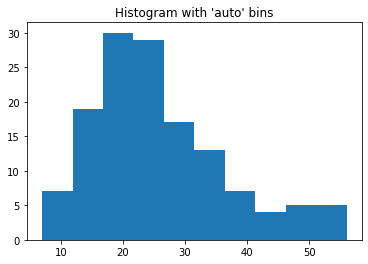

Max score  56
Min score  7
For boundaries: [0, 26]
Matches found 133 of 136 predictions 
Performance: 22.56%
Correct predictions:  30
Incorrect predictions:  103
For boundaries: [8, 26]
Matches found 133 of 136 predictions 
Performance: 24.81%
Correct predictions:  33
Incorrect predictions:  100
For boundaries: [12, 26]
Matches found 133 of 136 predictions 
Performance: 27.07%
Correct predictions:  36
Incorrect predictions:  97
For boundaries: [14, 26]
Matches found 133 of 136 predictions 
Performance: 27.82%
Correct predictions:  37
Incorrect predictions:  96
For boundaries: [16, 26]
Matches found 133 of 136 predictions 
Performance: 31.58%
Correct predictions:  42
Incorrect predictions:  91
For boundaries: [18, 26]
Matches found 133 of 136 predictions 
Performance: 32.33%
Correct predictions:  43
Incorrect predictions:  90
For boundaries: [20, 26]
Matches found 133 of 136 predictions 
Performance: 37.59%
Correct predictions:  50
Incorrect predictions:  83
For boundaries: [22, 26]
Mat

In [14]:
mySearchEngine = SearchEngine()
mySearchEngine.run()